### Housing Violations Dataset Exploration


Now that we have all of our data, we want to start finding trends and visualizing it. We come into this asking some very elementary questions; Where are incidents most common? What time of year do most incidents occur in? Are there any peculiar trends? First though, we need to see the shape of our data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [2]:
#import our data
df = pd.read_csv('../data/clean.csv', parse_dates = ['inspectiondate',
                                                     'currentstatusdate']).drop('newcorrectbydate',axis=1)

In [3]:
df.count()

violationid              49377
buildingid               49377
boro                     49377
zip                      49375
inspectiondate           49377
originalcorrectbydate    48730
novdescription           49377
class                    49377
currentstatus            49377
currentstatusdate        49377
currentstatusdate        49377
dtype: int64

So we see we have a lot of rows to work with. Now on a most basic level we want to see what the status of these violations are

In [4]:
statusCounts = df.currentstatus.value_counts()
statusCounts

VIOLATION CLOSED                            41461
VIOLATION DISMISSED                          4110
FIRST NO ACCESS TO RE- INSPECT VIOLATION     1410
NOT COMPLIED WITH                            1265
NOV SENT OUT                                  556
DEFECT LETTER ISSUED                          175
NOV CERTIFIED LATE                            171
SECOND NO ACCESS TO RE-INSPECT VIOLATION      134
VIOLATION WILL BE REINSPECTED                  28
INVALID CERTIFICATION                          22
INFO NOV SENT OUT                              20
FALSE CERTIFICATION                            19
NOTICE OF ISSUANCE SENT TO TENANT               3
CIV14 MAILED                                    2
VIOLATION REOPEN                                1
Name: currentstatus, dtype: int64

Interestingly enough, most of the cases are closed. Now what can cause a violation to be closed? According to the dataset description... `The violation status is closed when the violation is observed/verified as corrected by HPD or as certified by the landlord.`

This leads to a noteworthy first observation: *Most violations are in fact corrected for*.

Now of the ones that aren't... some have been dissmissed. Some were not complied with, and others are still in the early stages of processing. Let's normalize these numbers by turning them into percents so that they are easier to look at. 

In [5]:
total = df.currentstatus.value_counts().sum()
statusCounts/total * 100

VIOLATION CLOSED                            83.968244
VIOLATION DISMISSED                          8.323713
FIRST NO ACCESS TO RE- INSPECT VIOLATION     2.855581
NOT COMPLIED WITH                            2.561922
NOV SENT OUT                                 1.126030
DEFECT LETTER ISSUED                         0.354416
NOV CERTIFIED LATE                           0.346315
SECOND NO ACCESS TO RE-INSPECT VIOLATION     0.271381
VIOLATION WILL BE REINSPECTED                0.056707
INVALID CERTIFICATION                        0.044555
INFO NOV SENT OUT                            0.040505
FALSE CERTIFICATION                          0.038479
NOTICE OF ISSUANCE SENT TO TENANT            0.006076
CIV14 MAILED                                 0.004050
VIOLATION REOPEN                             0.002025
Name: currentstatus, dtype: float64

Viewing the numbers like this makes it really clear that most cases were closed, a whopping 80 percent.

Now this begs the obvious question: Why?
Here are a couple of possibilities...
1. Records tend to only be entered into the system when they are closed. 
2. We are looking at data from a very narrow time span.

Now 1 would be a data entry problem. 2 though we could really easily verify. Let's graph number of incidents per month...

In [6]:
df['monthCurrentStatus'] = df.currentstatusdate.dt.to_period('M') #First we extract the months/year
sorted_df = df.sort_values('monthCurrentStatus') 

In [7]:
counts = sorted_df.groupby('monthCurrentStatus').count().sum(axis=1) #Yes we could use value_counts but then we have to resort
counts.head()

monthCurrentStatus
2008-06    286
2008-07     11
2008-08     11
2008-09     44
2008-10     22
Freq: M, dtype: int64

Text(0.5, 1.0, 'Number of Incidents Statuses over Time')

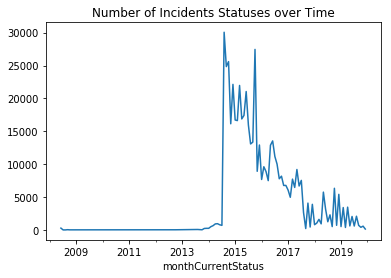

In [8]:
counts.plot()
plt.title("Number of Incidents Statuses over Time")

Now we immediatly see that a lot our incidents were torwards the end of 2014 and less were reported since then. 
This doesn't iteself answer our original question of why are almost all the statuses closed but it seems like most of the data was entered during this period when the data was marked as completed.

Now this is really odd... This is why. Remember how at the botumn of the previous <a href = https://github.com/harisx91/NYCHousingMaintenanceCodeProject/blob/master/notebooks/HousingCleaning.ipynb> notebook </a> I said that the Socrata API was not giving us a random sample? We can prove it here...

We have a count of how many incidents occured in 2016, 2017, and 2018 from the previous notebook Let's eyeglance (not using statistics) if the numbers match these. 

In [43]:
df_2018 = pd.read_csv('../data/inspection_2018.csv')
df_2017 = pd.read_csv('../data/inspection_2017.csv')
df_2016 = pd.read_csv('../data/inspection_2016.csv')
df_2015 = pd.read_csv('../data/inspection_2015.csv')
df_2014 = pd.read_csv('../data/inspection_2014.csv')
df_2013 = pd.read_csv('../data/inspection_2013.csv')
df_2012 = pd.read_csv('../data/inspection_2012.csv')

In [44]:
print('There are {:d} records in 2016 '.format(len(df_2016)))
print('There are {:d} records in 2017 '.format(len(df_2017)))
print('There are {:d} records in 2018 '.format(len(df_2018)))
print('There are {:d} records in 2014 '.format(len(df_2014)))

There are 513534 records in 2016 
There are 556883 records in 2017 
There are 642850 records in 2018 
There are 397234 records in 2014 


And by inspection on the graph... we can clearly see that this ratio does not hold. 2018 should have the most. Instead we have the increase in 2014. This is why in order to answer the question about what season incidents occur in we can't actually use this data. We can note something interesting, namely that `the number of incidents are increasing per year`. In 2018 642849 incidents occured while in 2014 only 299592. This number is abnormally large so we suspect there is inconsistency with how incidents were recorded during 2014. Let's see if this is true also by class.

In [45]:
df = pd.concat([df_2012, df_2013, df_2014,df_2015, df_2016, df_2017, df_2018])
df.rename(columns={'boro': 'borough'}, inplace=True) # rename since it is spelled wrong
df['inspectiondate'] = pd.to_datetime(df['inspectiondate'])
df['year'] = df.inspectiondate.dt.to_period('Y')

In [46]:
group = df.groupby(['year', 'class']).size()


In [48]:
years = ['2012','2013','2014','2015','2016','2017','2018']
a = []
b = []
c = []
for i in range(2012,2019,1):
    a.append(group[str(i)]['A'])
    b.append(group[str(i)]['B'])
    c.append(group[str(i)]['C'])

Text(0.5, 1.0, 'Incidents Per Year')

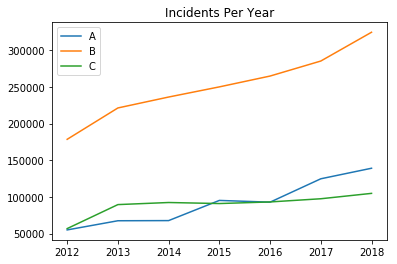

In [49]:
plt.plot(years,a)
plt.plot(years,b)
plt.plot(years,c)
plt.legend(['A','B','C'])
plt.title('Incidents Per Year')

Let's calculate the percentage of difference per year for each class.

In [50]:
f = df.groupby(['year', 'class']).size()
f = f.reset_index().set_index('year')
f = pd.DataFrame(f)
f['difff'] = f.iloc[:,1
      ].pct_change(periods=4)
f

,class,0,difff
year,,,
2012,A,54913,NaN
2012,B,178451,NaN
2012,C,56724,NaN
2012,I,1173,NaN
2013,A,67412,0.227615
2013,B,221219,0.239662
2013,C,89438,0.576722
2013,I,1627,0.387042
2014,A,67622,0.003115


And now let's see the min and max

In [51]:
f.groupby('class').agg({'difff':['min','max']})

difff           
            min        max
class                     
A     -0.024893  0.406746 
B      0.058631  0.239662 
C     -0.015311  0.576722 
I     -0.448402  92.385119

Even though the number of incident B is the highest one but its maximum of the changes is the lowest,  the highest changes is for incident I but since it does not have that number of incidents maybe it is not worth it to investigate more but the changes of incident C is markable and need more attentions!

Now going back... Are most incidents really closed or is this just how they are indexed?

In [11]:
counts = df_2016.currentstatus.value_counts()
counts/counts.sum()

VIOLATION CLOSED                            0.491214
VIOLATION DISMISSED                         0.295137
NOV SENT OUT                                0.111928
INFO NOV SENT OUT                           0.030781
NOT COMPLIED WITH                           0.026431
FIRST NO ACCESS TO RE- INSPECT VIOLATION    0.022628
INVALID CERTIFICATION                       0.007076
NOV CERTIFIED LATE                          0.006268
SECOND NO ACCESS TO RE-INSPECT VIOLATION    0.002434
VIOLATION WILL BE REINSPECTED               0.001579
DEFECT LETTER ISSUED                        0.001386
FALSE CERTIFICATION                         0.001209
CERTIFICATION POSTPONMENT DENIED            0.000831
CERTIFICATION POSTPONMENT GRANTED           0.000672
CIV14 MAILED                                0.000269
NOV CERTIFIED ON TIME                       0.000127
VIOLATION REOPEN                            0.000018
VIOLATION OPEN                              0.000012
Name: currentstatus, dtype: float64

This confirms that most violations are indeed closed. A large number also tend to be dismissed. Only 2 percent are not complied with which is good. Very few get postpowned which we already knew from the first notebook. See the data description for the details of each one of these as this is not very important. We should question `why are so many incidents being raised only to be dismissed`. Answering this requires information outside of our control since the data does not tell us why incidents are dismissed.The most we can do is look at the nov description for some of these. We need to use the clean.csv since this file became too big to add the nov description.

In [12]:
dismiss = df[df.currentstatus == 'VIOLATION DISMISSED'].reset_index()
dismiss.novdescription.head(2)

0    SECTION 27-2098 ADM CODE  FILE WITH THIS DEPAR...
1    SECTION 27-2098 ADM CODE  FILE WITH THIS DEPAR...
Name: novdescription, dtype: object

It's so lovely how these are being cut off...
Let's directly get the codes. They seem very googalable. 
See https://up.codes/viewer/new_york_city/nyc-housing-maintenance-code/chapter/3/physical-and-occupancy-standards-for-dwelling-units#3_6

In [13]:
dismiss.novdescription.str.extract('(SECTION [0-9]{2}-[0-9]{4})').head(10)

,0
0,SECTION 27-2098
1,SECTION 27-2098
2,SECTION 27-2098
3,NaN
4,SECTION 27-2005
5,SECTION 27-2013
6,SECTION 27-2098
7,NaN
8,NaN
9,SECTION 27-2098


A couple don't seem to match... Let's see why

In [14]:
dismiss.head(10)

,index,violationid,buildingid,boro,zip,inspectiondate,originalcorrectbydate,novdescription,class,currentstatus,currentstatusdate,currentstatusdate,monthCurrentStatus
0,45,1001061,141606,BROOKLYN,11215.0,1997-04-11,2009-12-05,SECTION 27-2098 ADM CODE FILE WITH THIS DEPAR...,A,VIOLATION DISMISSED,2015-03-10,2015-03-10,2015-03
1,46,1001065,141608,BROOKLYN,11215.0,1997-04-11,2009-12-05,SECTION 27-2098 ADM CODE FILE WITH THIS DEPAR...,A,VIOLATION DISMISSED,2015-03-10,2015-03-10,2015-03
2,137,1002346,141792,BROOKLYN,11215.0,1996-11-06,2006-11-24,SECTION 27-2098 ADM CODE FILE WITH THIS DEPAR...,A,VIOLATION DISMISSED,2015-03-10,2015-03-10,2015-03
3,144,1002429,141835,BROOKLYN,11204.0,1990-09-12,2008-06-26,D26-10.01 ADM CODE & 309 M/D LAW ABATE THE NU...,B,VIOLATION DISMISSED,2014-08-20,2014-08-20,2014-08
4,155,1002480,141835,BROOKLYN,11204.0,1990-09-12,2008-06-26,SECTION 27-2005 ADM CODE PROPERLY REPAIR THE ...,B,VIOLATION DISMISSED,2014-08-20,2014-08-20,2014-08
5,156,1002481,141835,BROOKLYN,11204.0,1990-09-12,2008-08-25,SECTION 27-2013 ADM CODE PAINT WITH LIGHT COL...,A,VIOLATION DISMISSED,2014-08-20,2014-08-20,2014-08
6,183,1002597,141853,BROOKLYN,11204.0,1997-04-11,2006-11-24,SECTION 27-2098 ADM CODE FILE WITH THIS DEPAR...,A,VIOLATION DISMISSED,2015-03-10,2015-03-10,2015-03
7,184,1002602,141855,BROOKLYN,11204.0,1980-04-23,2009-09-10,D26-41.05 ADM CODE FILE WITH THIS DEPARTMENT ...,B,VIOLATION DISMISSED,2015-03-10,2015-03-10,2015-03
8,185,1002604,141855,BROOKLYN,11204.0,1982-05-07,2009-11-09,D26-41.03 ADM CODE FILE WITH THIS DEPARTMENT ...,A,VIOLATION DISMISSED,2015-03-10,2015-03-10,2015-03
9,186,1002608,141855,BROOKLYN,11204.0,1990-10-19,2009-11-09,SECTION 27-2098 ADM CODE FILE WITH THIS DEPAR...,A,VIOLATION DISMISSED,2015-03-10,2015-03-10,2015-03


They seem to be written in this D## Format. Let's change our regex.

In [15]:
codes = dismiss.novdescription.str.extract('((SECTION [0-9]{2}-[0-9]{4})|D[0-9]{2}-[0-9]{2}\.[0-9]{2})')[0]

In [16]:
codes.isnull().sum()

713

We still have nulls but I'm not going to go crazy matching every single one. Let's see if some incidents are more common than others. 

In [17]:
codes.value_counts()

SECTION 27-2029    1213
SECTION 27-2005     910
SECTION 27-2028     325
SECTION 27-2018     174
SECTION 27-2045     139
SECTION 27-2026     139
SECTION 27-2046     129
SECTION 27-2013     119
SECTION 27-2098      37
SECTION 27-2040      32
SECTION 27-2031      28
SECTION 27-2043      19
SECTION 27-2024      15
D26-41.03            12
SECTION 26-1103      11
SECTION 27-2070      11
SECTION 27-2053      10
D26-10.01             9
SECTION 27-2104       7
SECTION 27-2037       7
SECTION 27-2056       6
SECTION 27-2073       5
SECTION 27-2087       5
SECTION 27-2010       4
SECTION 27-2039       2
SECTION 27-2041       2
D26-17.10             2
SECTION 27-2050       2
D26-21.03             1
SECTION 27-2011       1
D26-20.08             1
SECTION 27-2142       1
SECTION 27-2065       1
SECTION 27-2047       1
SECTION 27-2100       1
SECTION 27-2032       1
D26-19.07             1
SECTION 27-2101       1
SECTION 27-2023       1
D26-41.05             1
SECTION 27-2077       1
SECTION 27-2089 

We can google each of these violations but it's not very exciting. SECTION 27-2029 has to do with the minimum temperature a house has to have. See https://nyclaws.readthedocs.io/nycadmincode/t27/c02/sch02/art08/
Section 205 has to do with the owner needing to keep the apartment in good repair. https://nyclaws.readthedocs.io/nycadmincode/t27/c02/sch02/art01/

Let's now see how severe dismissed incidents are...

In [18]:
dismiss['class'].value_counts()

C    1875
B    1240
A     521
I     474
Name: class, dtype: int64

This is actually really interesting. Most dismissed incidents are of high severity. We will see below in Elham's analysis that this ratio is different than the general ratio. 

While we are doing, let's also see what incidents are most common amung closed incidents.

In [19]:
closed = df[df.currentstatus == 'VIOLATION CLOSED'].reset_index()

In [20]:
codes = closed.novdescription.str.extract('((SECTION [0-9]{2}-[0-9]{4})|D[0-9]{2}-[0-9]{2}\.[0-9]{2})')[0]

In [21]:
codes.value_counts().head(5)

SECTION 27-2005    19696
SECTION 27-2026     3962
SECTION 27-2013     2667
SECTION 27-2046     2546
SECTION 27-2045     2382
Name: 0, dtype: int64

It's interesting that a large majority fall under SECTION 27-2005. We've already seen that this is a general violation of an owner not keeping his apartment in good repair. It is not surprising that this law is most violated since this law is the most general. Note multiple violation codes are inserted in one cell and it is hard to find all the codes violated within each string so I'm only selecting the first. It would be helpful if the data was normalized into a violation table with an incident_id column and a violation_code column... rather than one giant string of violations along with descriptions which I don't know who in the world would think is a good idea because as it is now that column is one big garbage dump. 

Either way, next on the list is 2026 which has to do with plumbing. 2013 has to do with the owner not painting properly. 2046 has to do with Carbon Monoxide detectors. These seem to be the things to look out for the most when selecting apartments with the caveat a lot of aparments have owners that don't 'keep their apartment in good repair' whatever that means.


#### Are there buildings with more than one incident

In [22]:
df.buildingid.value_counts().head(5)

57762     207
116935    187
7206      173
97967     109
81719     109
Name: buildingid, dtype: int64

Yes... but why? We know that some buildings are composed of more than one houses. Still 207 incidents seems like a lot. Let's look at the nov descriptions for some of these. I'm also curious about how many incidents this building has had in total

In [23]:
building = pd.read_csv("https://data.cityofnewyork.us/resource/wvxf-dwi5.csv?$query=Select%20inspectiondate,novdescription,currentstatus%20where%20buildingid=57762", parse_dates = ['inspectiondate'])

In [24]:
pd.set_option('display.max_colwidth', -1)
len(building)

975

Nice... This building has close to 1,000 incidents. 

In [25]:
building.head(20)

,inspectiondate,novdescription,currentstatus
0,2019-08-14,"SECTION 27-2046.1 HMC: REPAIR OR REPLACE THE CARBON MONOXIDE DETECTING DEVICE(S). MISSING LOCATED AT APT 25, 2nd STORY, 1st APARTMENT FROM NORTH AT EAST",VIOLATION DISMISSED
1,2019-08-14,"SECTION 27-2045 ADM CODE REPAIR OR REPLACE THE SMOKE DETECTOR MISSING LOCATED AT APT 25, 2nd STORY, 1st APARTMENT FROM NORTH AT EAST",VIOLATION DISMISSED
2,2019-08-14,"SECTION 27-2026, 2027 HMC: PROPERLY REPAIR THE SOURCE AND ABATE THE EVIDENCE OF A WATER LEAK AT CEILING IN THE 2nd ROOM FROM NORTH LOCATED AT APT 25, 2nd STORY, 1st APARTMENT FROM NORTH AT EAST",VIOLATION DISMISSED
3,2019-08-14,"SECTION 27-2026, 2027 HMC: PROPERLY REPAIR THE SOURCE AND ABATE THE EVIDENCE OF A WATER LEAK AT CEILING IN THE BATHROOM LOCATED AT APT 25, 2nd STORY, 1st APARTMENT FROM NORTH AT EAST",VIOLATION DISMISSED
4,2019-08-14,"SECTION 27-2026 ADM CODE REPAIR THE BROKEN OR DEFECTIVE CONNECTION WASTE LINE AT SINK. IN THE KITCHEN LOCATED AT APT 25, 2nd STORY, 1st APARTMENT FROM NORTH AT EAST",VIOLATION DISMISSED
5,2019-08-14,"SECTION 27-2005 ADM CODE REPLACE WITH NEW THE BROKEN OR DEFECTIVE ELECTRICAL OUTLET AT NORTH WALL IN THE KITCHEN LOCATED AT APT 25, 2nd STORY, 1st APARTMENT FROM NORTH AT EAST",VIOLATION DISMISSED
6,2019-08-14,"SECTION 27-2005 ADM CODE PROPERLY REPAIR WITH SIMILAR MATERIAL THE BROKEN OR DEFECTIVE WOOD FLOOR IN THE 2nd ROOM FROM NORTH LOCATED AT APT 25, 2nd STORY, 1st APARTMENT FROM NORTH AT EAST",VIOLATION DISMISSED
7,2019-06-24,SECTION 62 M/D LAW REARRANGE TELEVISION AND/OR RADIO ANTENNA TO BE AT LEAST 10 FEET ABOVE ROOF AND NOT ATTACHED TO ANY FIRE ESCAPE OR SOIL OR VENT LINE AT 5HT STORY BULCONY AT BUILDING FRONT AT EAST AT NORTH AT FIRE ESCAPE,VIOLATION DISMISSED
8,2019-06-24,SECTION 62 M/D LAW REARRANGE TELEVISION AND/OR RADIO ANTENNA TO BE AT LEAST 10 FEET ABOVE ROOF AND NOT ATTACHED TO ANY FIRE ESCAPE OR SOIL OR VENT LINE AT 4TH STORY BULCONY AT BUILDING FRONT AT EAST AT NORTH AT FIRE ESCAPE,VIOLATION DISMISSED
9,2019-06-24,SECTION 62 M/D LAW REARRANGE TELEVISION AND/OR RADIO ANTENNA TO BE AT LEAST 10 FEET ABOVE ROOF AND NOT ATTACHED TO ANY FIRE ESCAPE OR SOIL OR VENT LINE AT 3RD STORY BULCONY AT BUILDING FRONT AT EAST AT NORTH AT FIRE ESCAPE,VIOLATION DISMISSED


In [26]:
building.novdescription.value_counts().head(5)

SECTION 27-2026, 2027 HMC: PROPERLY REPAIR THE SOURCE AND ABATE THE EVIDENCE OF A WATER LEAK AT CEILING  IN THE 3rd ROOM  FROM EAST AT SOUTH LOCATED AT APT 11, 1st STORY, 1st APARTMENT FROM EAST AT SOUTH                                7
SECTION 27-2043.1 HMC INSTALL THE MISSING OR REPAIR/REPLACE THE DEFECTIVE WINDOW GUARD(S) THROUGHOUT THE PUBLIC AREAS IN ACCORDANCE WITH THE SPECIFICATIONS OF THE NEW YORK CITY HEALTH CODE SECTION 24 RCNY CHAPTER 12. AT PUBLIC HALL    5
SECTION 27-2005 ADM CODE  REPAIR THE BROKEN OR DEFECTIVE PLASTERED SURFACES AND PAINT IN A UNIFORM COLOR THE CEILING  IN THE 3rd ROOM  FROM EAST AT SOUTH LOCATED AT APT 11, 1st STORY, 1st APARTMENT FROM EAST AT SOUTH                   4
SECTION 27-2026, 2027 HMC: PROPERLY REPAIR THE SOURCE AND ABATE THE EVIDENCE OF A WATER LEAK AT CEILING  IN THE 3rd ROOM  FROM EAST AT NORTH LOCATED AT APT 11, 1st STORY, 1st APARTMENT FROM EAST AT SOUTH                                3
SECTION 27-2005 ADM CODE  PROPERLY REPAIR WITH SIMIL

It's unclear why the same description is listed so many times. Are they both updating old rows with the violation status and creating a new row every time they update the status? Are they just duplicating the rows? This is really unclear. It's unlikely though that a single building has this many incidents are we attribute buildings having multiple incidents to a data collection problem. 

I'm inclined to believe they are updating old rows. That would explain why so many violations are closed and so few are open but there seems to be some inconsistency with what they are doing since if that is true then why are there duplicates? How are they treating incidents that are reopened. This is really vague. 

#### What season do most incidents occur in

From the city's perspective, this is very important. It can help with planning how much staff is needed. From a building owner's viewpoint, it is important to know when issues arise so that they can be prepared to fix the issues.

Let's create simple plots to try to visualize this

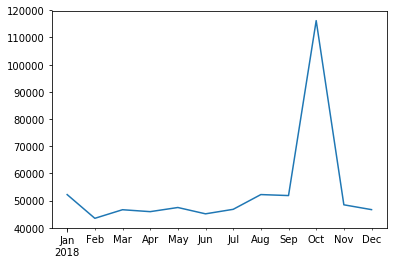

In [27]:
series = df_2018.inspectiondate.dt.to_period('M')
sortedcounts = series.value_counts().sort_index()
sortedcounts.plot()

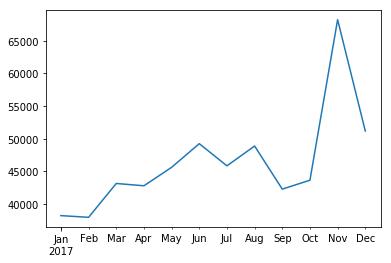

In [28]:
series = df_2017.inspectiondate.dt.to_period('M')
sortedcounts = series.value_counts().sort_index()
sortedcounts.plot()

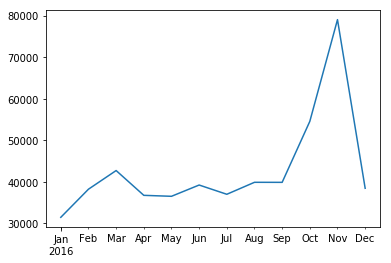

In [29]:
series = df_2016.inspectiondate.dt.to_period('M')
sortedcounts = series.value_counts().sort_index()
sortedcounts.plot()

It appears that most incidents are raised during the Fall, in either October and Novemeber

Let's take 2016 as an example. Although it appears that November has an overwhelming majority of incidents, we can do a statistical test to see if it is possible that this is just do to chance. 

Let's model this as a bernoulli random variable since there are 2 possibilities here. Either an inspection was in November or it wasn't. If all months had an equal number of incidents per month we would expect that each month would have 100/12 or 25/3 (8.3) percent of the incidents each month. Let's get what the percentage of incidents in November.

In [30]:
n = sortedcounts.sum()
p = sortedcounts['2016-11']/n
q = 1-p
p

0.1538612827972442

We see that November had 15.4 percent of the incidents... Almost twice as much as what we would expect the avg month to have.  
Now let's see the Probability that we would get this 15.4 percent if really there was no significant difference. We can state this in another way with a hypothesis test. 

Our null hypthosis is there is no significant difference
Our alternate hypothesis is that there is... That is, P(incident in November) >= 8.3%. 


An easy approach we can take is to make a confidence interval. This interval would give us a range of possible values that the true probability is.

We know from basic statistics we have the point estimator for target `p` with standord error `sqrt(pq/n`)`

In [31]:
import math
standordError = math.sqrt(p * q /n)
standordError

0.000503501602425762

In [32]:
er = 1.96 * standordError
lowerBound,upperBound = (p - er, p+er)
lowerBound,upperBound


(0.1528744196564897, 0.1548481459379987)

These numbers tell us that there is a 95% chance that the true value is between .1528, and .1548. Since 8.3 is not in the interval, we can say with 95 percent accuracy that there is a significant difference and more incidents are indeed opened in November. Moreover, from how far away this range is from 8.3, it is pretty clear that there is a wide gap.

So what do we gain from knowing this? Firstly, we reccomend that the city have lots of staff around for inspecting buildings during this period. We also recomend that building owners look to correct the issues in their buildings before fall so that they can be prepared for inspections.

#### Where do incidents take place

So now we contextualized our data a bit more... We know when the data was from and we know the what: that most of the rows show that the incidents were resolved. Let's now focus more on how severe the incidents were and where most incidents take place.

Text(0.5, 1.0, 'Incidents per boro')

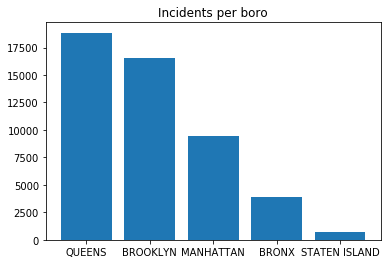

In [33]:
plt.bar(df['boro'].unique(), df['boro'].value_counts())
plt.title("Incidents per boro")

Queens has the most number of incidents and Staten Island the least.
It's not just that there are more incidents though. The ratio of incidents between Queens and Brooklyn and the other boros is significantly more. We should investigate why this is. Is there something problematic about these buildings like are they older?

It's also important though to see how severe these incidents are...

In [34]:
df['class'].value_counts()

B    30368
C    9301 
A    9061 
I    647  
Name: class, dtype: int64

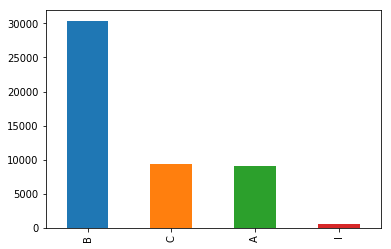

In [35]:
class_counts = df['class'].value_counts()
class_counts.plot.bar()

As we can see class B(which is medium severe) has the highest number. C is high severity and is about equal with A (low severity). I incidents aren't really violations but simply notifications. Now let's see if there are overly many severe incidents in any boros

In [36]:
df.groupby(['boro','class']).size()

boro           class
BRONX          A        3127 
               B        10480
               C        2806 
               I        108  
BROOKLYN       A        3438 
               B        11404
               C        3697 
               I        309  
MANHATTAN      A        1753 
               B        5765 
               C        1840 
               I        87   
QUEENS         A        645  
               B        2246 
               C        827  
               I        137  
STATEN ISLAND  A        98   
               B        473  
               C        131  
               I        6    
dtype: int64

Since Brooklyn has the highest number of incident, it makes sense that largest class incident happens there. 

It is easier to read if sorted

In [37]:
df.groupby(['boro','class']).size().sort_values(ascending=False)

boro           class
BROOKLYN       B        11404
BRONX          B        10480
MANHATTAN      B        5765 
BROOKLYN       C        3697 
               A        3438 
BRONX          A        3127 
               C        2806 
QUEENS         B        2246 
MANHATTAN      C        1840 
               A        1753 
QUEENS         C        827  
               A        645  
STATEN ISLAND  B        473  
BROOKLYN       I        309  
QUEENS         I        137  
STATEN ISLAND  C        131  
BRONX          I        108  
STATEN ISLAND  A        98   
MANHATTAN      I        87   
STATEN ISLAND  I        6    
dtype: int64

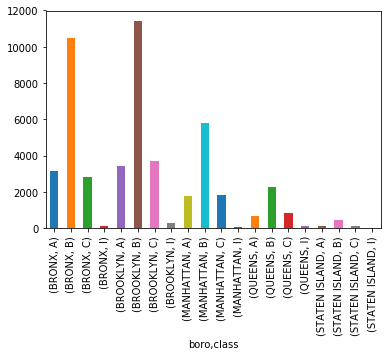

In [38]:
df.groupby(['boro','class']).size().plot.bar()

We don't see any boro which violates this ratio of having more class B incidents. Because of this we don't feel a need to propose any immediate action, however we do think this situation should be monitored in case it gets worse. 

It might be usefull to see what this data looks like on a map. Let's create a map with dots representing how many incidents there were in certain zip codes. This will let us put more data into our graphs since the bar graph above already is bordering on the max number of bars

In [39]:
zipCounts = pd.read_csv(r'../data/zip_count.csv')

In [41]:
import plotly
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *

init_notebook_mode(connected=True)
token = 'pk.eyJ1IjoiYmNvaGVuOSIsImEiOiJjazMyYWF5OHYwYTZ3M25ubzFmMTRiNnNtIn0.8Kusg2VIJV3-cV2L2V7uHA'
px.set_mapbox_access_token(token) # You need a mapbox token to see the graph

fig = px.scatter_mapbox(zipCounts, lat="long", lon="lat", hover_name="city", hover_data=['zip','count'], # Yes, I flipped lat and long by accident
                        size = "count")
fig.update_layout(mapbox_style="light")
fig.update_layout(margin={"r":0,"t":100,"l":0,"b":0}, title = "Incidents per Zip")
plotly.offline.iplot(fig)

This graph shows the number of incidents in an area. The larger the circle, the more incidents To use this graph, simply click and drag to move around and use the mouse wheel to zoom in and out.


Hovering over any of the circles shows which zip code it is agregating over, the name of the city, and the number of incidents there. This graph is good because of how much data it is showing. We see that there are definetly areas where there are a lot of housing incidents.

This is really important when it comes to renting an apartment. This graph indicates areas where buildings tend to have lots of problems. A small disclaimer with this graph is that it is possible that some areas have more incidents just because there are more people. This is why we can't make any reccomendations from this graph. 

Now let's try to see if there is anything problematic about how long each boroough takes to respond to incidents. If there is a borough that takes too long,that would indicate problems with how incidents are being dealt with.  

In [22]:
inspection_date = df['inspectiondate']
current_status_date = df['currentstatusdate']

In [23]:
df['days_between'] = pd.to_timedelta(current_status_date - inspection_date, unit='d').dt.days
closed_issues = df[df['currentstatus'] == 'VIOLATION CLOSED']

In [24]:
daysOpenDf = closed_issues[['days_between', 'boro']]
daysOpenDf.head()

,days_between,boro
0,8066,QUEENS
1,7568,QUEENS
2,7568,QUEENS
3,7566,QUEENS
4,11005,BROOKLYN


In [25]:
daysOpenSeries = daysOpenDf.groupby('boro').median() #median to ignore outliers 

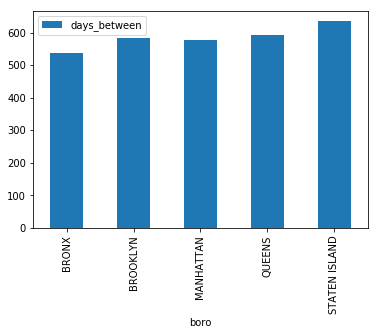

In [26]:
daysOpenSeries.plot.bar()

Staten Island seems to take the longest to repond to incidents. They also have the fewest number of incidents so this difference might not be significant. It's a pretty noteworthy observation that these numbers don't differ so much.
Although we found that certain boros have more incidents, the way they are dealt with is consistant and reasonable. This is good news! All that should be addressed is why Queens and Brooklyn have so many more incidents.  

### Summary

Apartment Seekers: So are there any areas where a future resident should avoid? Probably not. The spread of incidents is about equal in all areas. 
Are there any things future residents should look for? We know that the most common incidents are problems with carbon monoxide detectors, paining, and plumbing. 

Owners: Be most prepared for inspections during the fall months, paying attention to the common incidents above.

City: Consider improving data collection by recording the incidents and not having duplicates in the dataset. One building should not have 1000 incidents. Consider using this data to build monitors to send alerts when the number of incidents in a category exeeds a threshold.